# GAN - Mario Project
## CS 445 - Rishi Shah, Steven Li

In [1]:
#Libraries Import

import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import cv2

In [2]:
# Directory containing the images
directory = "Original"
output_dir = "Blocks"

## Data Processing

In [3]:
def norm(arr):
    return (arr - arr.min()) / (arr.max() - arr.min()+1e-6)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ssd_score(im1, im2):
    return np.sum(((im1 - im2)**2))

In [4]:
block_dir = "block_types"
block_types = []
for i, file in enumerate(sorted(os.listdir(block_dir))):
  if file.split('.')[-1] != 'png':
    continue
  block_types.append(np.array(Image.open(os.path.join(block_dir, file)).convert('L')))


In [5]:
color_block_types = []
for i, file in enumerate(sorted(os.listdir(block_dir))):
  if file.split('.')[-1] != 'png':
    continue
  color_block_types.append(np.array(Image.open(os.path.join(block_dir, file)).convert('RGB')))

In [6]:
def encode_image(image, block_types, block_size = 16, block_threshold = .5):
    encoded_image = np.zeros(tuple([x // block_size for x in image.shape[:2]] + [len(block_types) + 1]), dtype=bool) # increase number of classes to number of different blocks, +1 for background

    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            curr_block = image[i:i+block_size, j:j+block_size]
            if curr_block.shape != (block_size, block_size):
                continue
            for k in range(len(block_types)):
                if ssd_score(curr_block[1:-1,1:-1], block_types[k][1:-1, 1:-1]) < block_threshold:
                    encoded_image[i // block_size, j // block_size, k] = 1
                    break
                else:
                    encoded_image[i // block_size, j // block_size, -1] = 1 # last layer is background

    return encoded_image

In [7]:
def decode_image(image, block_types, block_size = 16, block_threshold = .5, use_color = False):
    # need to complete
    decoded_image = np.zeros(tuple([x * block_size for x in image.shape[:2]]))
    if use_color:
      decoded_image = np.stack([decoded_image] * 3, axis=2)

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        k = np.argmax(image[i, j, :])
        if k == len(block_types): # background
          continue
        else:
          if use_color:
            decoded_image[i*16:i*16+16, j*16:j*16+16, :] = block_types[k]
          else:
            decoded_image[i*16:i*16+16, j*16:j*16+16] = block_types[k]

    return decoded_image.astype(np.uint8)

In [8]:
# ONLY NEED TO RUN ONCE

processed_dir = "processed_images"
os.makedirs(processed_dir, exist_ok=True)
for existing_file in os.listdir(processed_dir):
    existing_filepath = os.path.join(processed_dir, existing_file)
    if os.path.isfile(existing_filepath):
        os.remove(existing_filepath)

# bad images
bad_images = ['mario-6-3.png', 'mario-8-3.png', 'mario-4-2.png', 'mario-1-2.png', 'mario-4-3.png', 'mario-5-3.png', 'mario-3-3.png', 'mario-1-3.png']

for file in os.listdir(directory):
  if file in bad_images:
    print(file)
    continue
  im = np.array(Image.open(os.path.join(directory, file)).convert('L'))
  output = encode_image(im, block_types)
  print(output.shape)
  # save as .npy or .pkl
  np.save(os.path.join(processed_dir, file), output)

(13, 202, 11)
mario-1-2.png
mario-1-3.png
(13, 197, 11)
(13, 197, 11)
(13, 208, 11)
mario-3-3.png
(13, 222, 11)
mario-4-2.png
mario-4-3.png
(13, 198, 11)
(13, 199, 11)
mario-5-3.png
(13, 184, 11)
(13, 215, 11)
mario-6-3.png
(13, 176, 11)
(13, 373, 11)
(13, 215, 11)
mario-8-3.png


In [9]:
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Block dimensions
block_width = 16
block_height = 16 # maybe pad height with 0s

count_of_images = 0
count_of_blocks = 0
for existing_file in os.listdir(output_dir):
    existing_filepath = os.path.join(output_dir, existing_file)
    if os.path.isfile(existing_filepath):
        os.remove(existing_filepath)


for file in os.listdir(processed_dir):
    filepath = os.path.join(processed_dir, file)
    # load numpy array
    data = np.load(filepath)
    top_padding = np.zeros((3, data.shape[1], data.shape[2]))
    top_padding[:, :, -1] = 1 # background
    data = np.append(top_padding, data, axis = 0) # padding to height 16

    # Get image dimensions
    img_width, img_height, _ = data.shape
    if img_width >= block_width and img_height >= block_height:
        count_of_images += 1
        for y in range(0, img_height, block_height):
            for x in range(0, img_width, block_width):
                # Ensure the block fits within the image
                if x + block_width <= img_width and y + block_height <= img_height:
                    # Crop the block
                    block = data[x:x+block_width, y:y+block_height, :].copy()

                    # Save the block
                    block_filename = f"{file.split('.')[0]}_block_{x}_{y}"
                    np.save(os.path.join(output_dir, block_filename), block)
                    count_of_blocks += 1

print("Count of Levels", count_of_images)
print("Training Images Avalible", count_of_blocks)

Count of Levels 12
Training Images Avalible 157


## GAN Setup and Traning


In [8]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# # Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [9]:
# Root directory for dataset
dataroot = output_dir

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 16

# Number of channels in the training images. For color images this is 3
nc = len(block_types) + 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [10]:
class Encoded_Im_Dataset(Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith(('.npy'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.files[idx]
        img = np.load(img_path).astype(np.float32)
        
        # Apply transformations, if any
        if self.transform:
            img = self.transform(img)
        
        return img

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = Encoded_Im_Dataset(dir=dataroot, transform=transforms.ToTensor())
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda")

In [12]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
# ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Conv2d( nz, ngf * 8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Dropout(.3), 
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # state size. ``(ngf*8) x 2 x 2``
            nn.Conv2d( ngf * 8, ngf * 4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout(.3), 
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # state size. ``(ngf*4) x 4 x 4``
            nn.Conv2d( ngf * 4, ngf * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout(.3), 
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # state size. ``(ngf*2) x 8 x 8``
            nn.Conv2d( ngf * 2, ngf, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Dropout(.3), 
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # state size. ``(ngf) x 16 x 16``
            nn.Conv2d( ngf, nc, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Dropout(.3), 
            nn.Conv2d( nc, nc, kernel_size=3, padding=1, bias=False),
            nn.Softmax(dim=0) # originally tanh
            # state size. ``(nc) x 16 x 16``
        )

    def forward(self, input):
        return self.main(input)


In [14]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Conv2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Upsample(scale_factor=2.0, mode='bilinear')
    (5): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Upsample(scale_factor=2.0, mode='bilinear')
    (10): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout(p=0.3, inplace=False)
    (14): Upsample(scale_factor=2.0, mode='bilinear')
    (15): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), 

In [15]:
# Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 16 x 16``
            nn.Conv2d(nc, ndf, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # state size. ``(ndf) x 8 x 8``
            nn.Conv2d(ndf, ndf * 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # state size. ``(ndf*2) x 4 x 4``
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # state size. ``(ndf*4) x 2 x 2``
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # state size. ``(ndf*8) x 1 x 1``
            nn.Conv2d(ndf * 8, 1, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv

In [17]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(5, nz, 1, 1, device=device)

lambda_gp = 10 # Gradient Penalty

real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=2*lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # increased to make generator learn faster than discriminator

In [18]:
# Training Loop
from tqdm import tqdm

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        for i in range(5):
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          ## Train with all-real batch
          netD.zero_grad()
          # Format batch
          real_cpu = data.to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          # Forward pass real batch through D
          output = netD(real_cpu).view(-1)
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          # Calculate gradients for D in backward pass
          errD_real.backward()
          D_x = output.mean().item()

          ## Train with all-fake batch
          # Generate batch of latent vectors
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          # Generate fake image batch with G
          fake = netG(noise)
          label.fill_(fake_label)
          # Classify all fake batch with D
          output = netD(fake.detach()).view(-1)
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, label)
          # Calculate the gradients for this batch, accumulated (summed) with previous gradients
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # Compute error of D as sum over the fake and the real batches
          errD = errD_real + errD_fake
          # Update D
          optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # check generator every 100 epochs and first and last epochs
    if (epoch == 0) or (epoch % 100 == 0) or (epoch == num_epochs-1):
        with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
        img_list.append(fake)

Starting Training Loop...


100%|██████████| 1000/1000 [16:53<00:00,  1.01s/it]


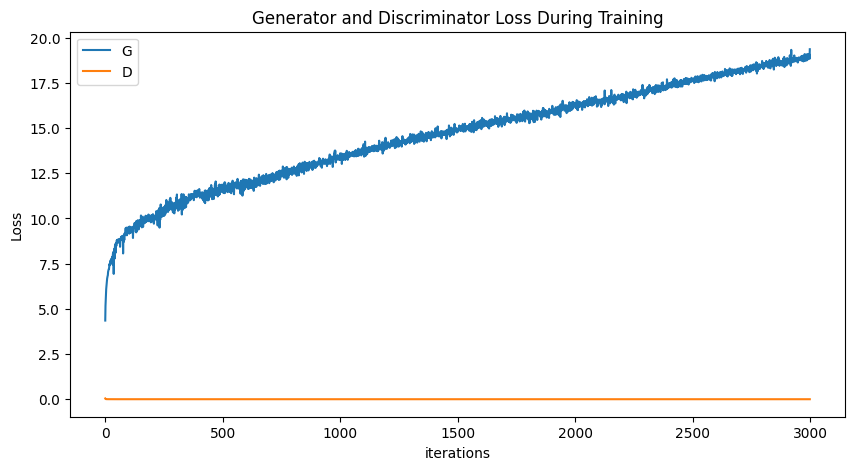

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

epoch num: 0


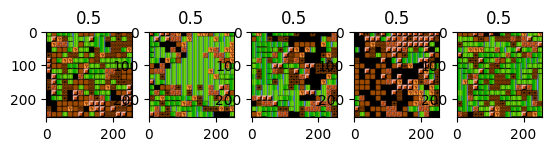

epoch num: 111


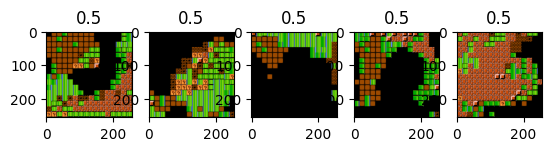

epoch num: 222


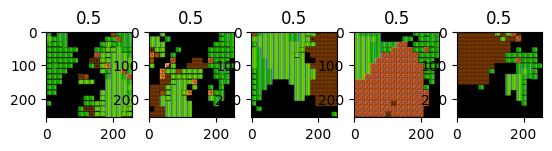

epoch num: 333


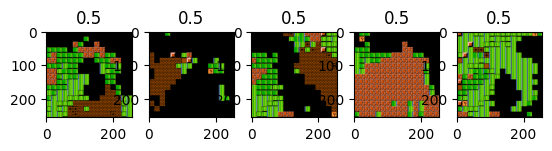

epoch num: 444


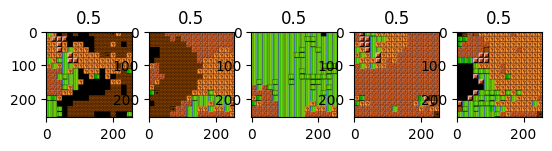

epoch num: 555


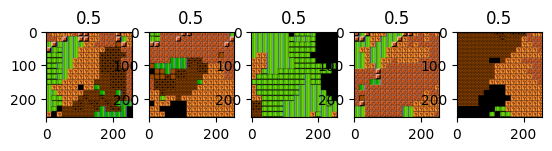

epoch num: 666


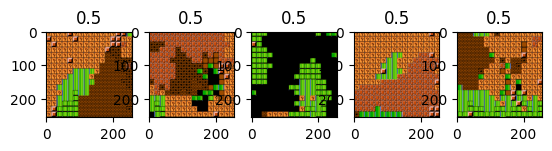

epoch num: 777


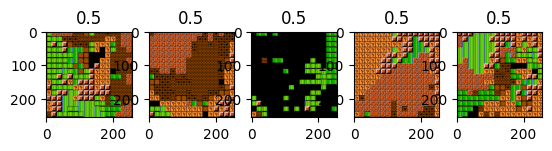

epoch num: 888


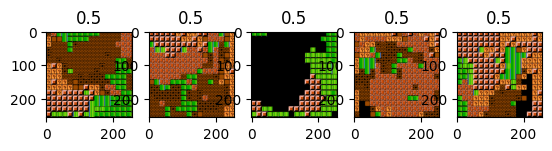

epoch num: 999


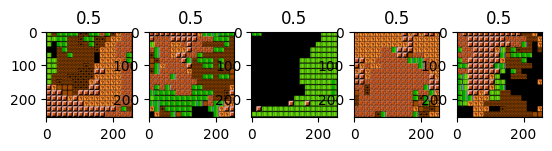

epoch num: 1110


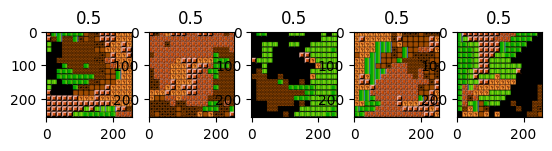

In [20]:
# Plot the fake images from the last epoch
for i in range(len(img_list)):
  print('epoch num:', i*(num_epochs // (len(img_list) - 2)))
  current_images = img_list[i]
  num_pics = current_images.shape[0]
  fig, axes = plt.subplots(1, num_pics)
  for j in range(num_pics):
    axes[j].imshow(decode_image(np.transpose(img_list[i][j, :, :, :].numpy(), (1, 2, 0)), color_block_types, use_color=True))
    with torch.no_grad():
      title = sigmoid(netD(torch.tensor(np.expand_dims(img_list[i][j, :, :, :], axis=0)).to(device)).detach().cpu().numpy().squeeze())
    axes[j].set_title(title)
  plt.show()